In [1]:
import statistics
import math

def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs


In [2]:
def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [3]:
def calculate_average_assignments(durations):
    count = count_assignments(durations)
    return count / len(durations)

def count_assignments(durations):
    count = 0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > 0:
                    count += 1
    return count

In [ ]:
from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os
includeWorkers = True
if includeWorkers:
    path = r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers'
    parser = WorkerBenchmarkParser()
else:
    path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks\all'
    parser = BenchmarkParser()
instances = os.listdir(path)
instance_data = []
feature_vectors = []
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features(encoding.durations()) if not includeWorkers else calculate_duration_features_workers(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    extracted_data = {
        "name": instance,
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(),
        "flexibility": calculate_flexibility(encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(), encoding.n_machines()),
        "duration_variety": calculate_duration_variety(encoding.durations()),
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "average_assignments": calculate_average_assignments(encoding.durations()),
        "n_assignments": count_assignments(encoding.durations()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    feature_vector = [encoding.n_jobs(), encoding.n_machines(), encoding.n_operations(), extracted_data["flexibility"], extracted_data["duration_variety"], extracted_data["average_operations"]]
    if consider_duration_features:
        feature_vector.extend([min_d, max_d, d_span, d_stdev])
    feature_vectors.append(feature_vector)
    instance_data.append(extracted_data)


In [14]:
from sklearn.cluster import KMeans
inertias = []
n_clusters = 20
centers = []
results = []
for i in range(1, n_clusters+1):
    kmeans = KMeans(n_clusters=i)
    results.append(kmeans.fit_predict(feature_vectors))
    centers.append(kmeans.cluster_centers_)
    
    inertias.append(kmeans.inertia_)


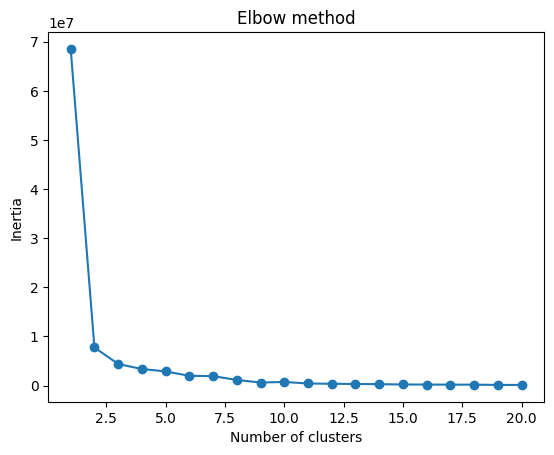

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,n_clusters+1), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [16]:
results[n_clusters-1]

array([14,  6,  6,  6,  6,  6,  3,  3,  3,  3,  2,  3,  2,  2,  2,  2,  2,
       17, 17, 17, 17,  2, 17,  6,  6,  6,  6,  6,  3,  3,  3,  3,  2,  3,
        2,  2,  2,  2,  2, 17, 17, 17, 17,  2, 17,  6,  6,  6,  6,  6,  3,
        3,  3,  3,  2,  3, 14, 14, 14, 14,  0, 19, 19,  6, 13, 13,  2,  2,
       19, 14, 14, 19, 14,  6,  7, 12, 12, 12, 12,  4,  4,  4,  4,  4,  4,
        2,  4,  4,  4,  4, 15, 15, 15, 15, 15,  0,  4,  0,  0,  0,  0, 11,
       11, 11, 11, 11,  0,  4,  0,  0,  0,  0,  4,  4, 13, 13, 13,  1, 16,
        1, 10,  1,  1,  1,  1,  1,  4,  4,  4, 16,  4,  4,  4, 17,  4,  4,
        4, 16, 16, 16, 12, 12, 12, 12, 12,  4,  4,  4,  4,  4,  4,  2,  4,
        4,  4,  4, 15, 15, 15, 15, 15,  0,  4,  0,  0,  0,  0, 11, 11, 11,
       11, 11,  0,  4,  0,  0,  0,  0,  4,  4, 13, 13, 13,  1, 16,  1, 10,
        1,  1,  1,  1,  1,  4,  4,  4, 16,  4,  4,  4, 17,  4,  4,  4, 16,
       16, 16, 12, 12, 12, 12, 12,  4,  4,  4,  4,  4,  4,  2,  4,  4,  4,
        4, 15, 15, 15, 15

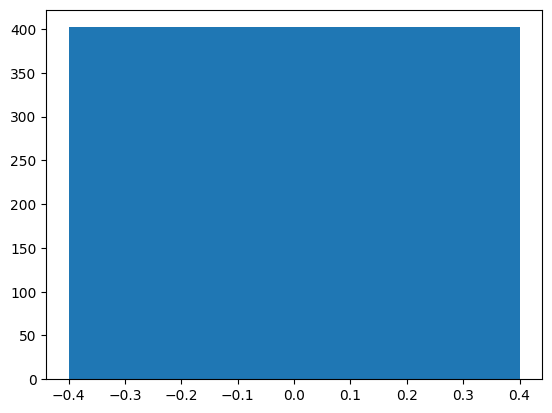

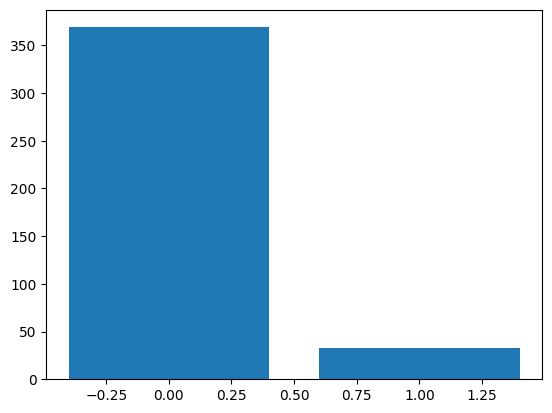

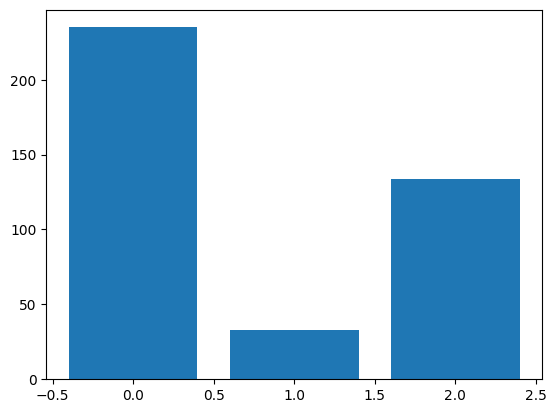

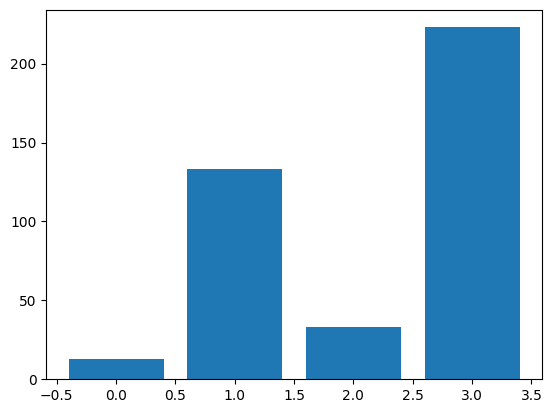

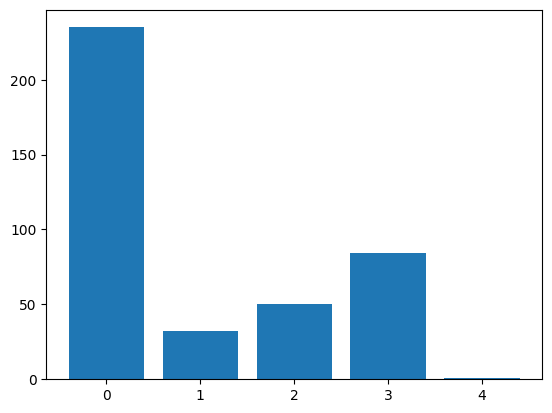

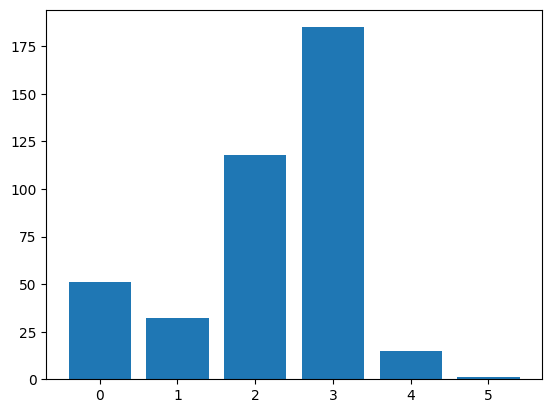

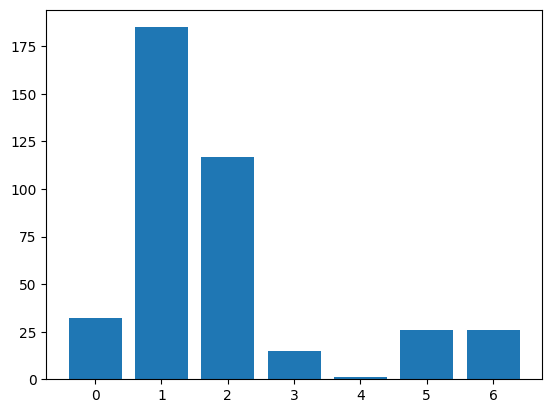

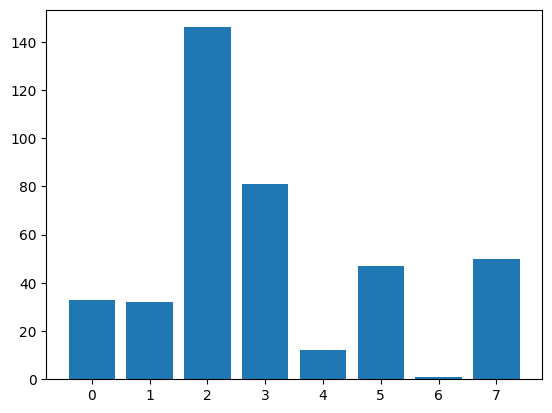

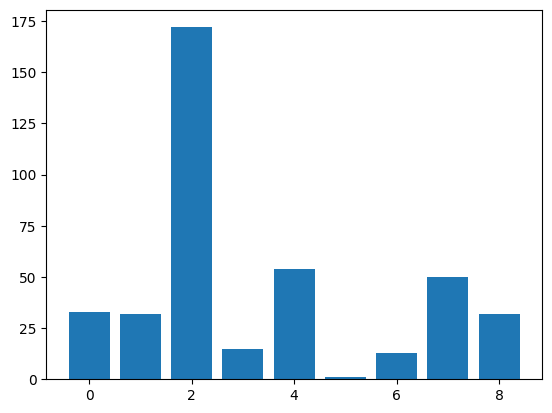

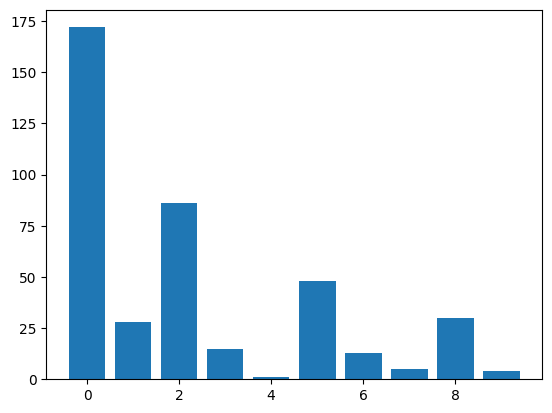

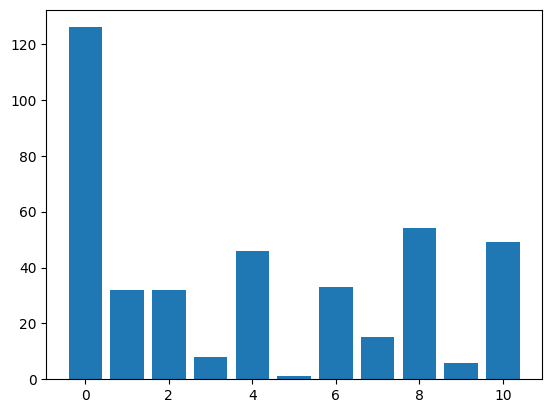

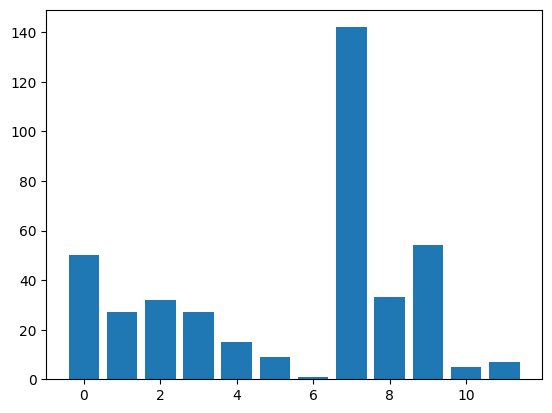

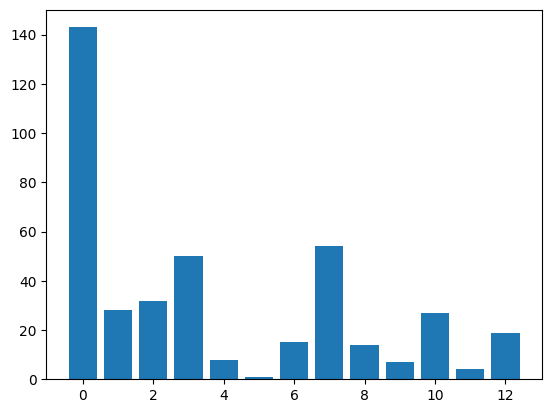

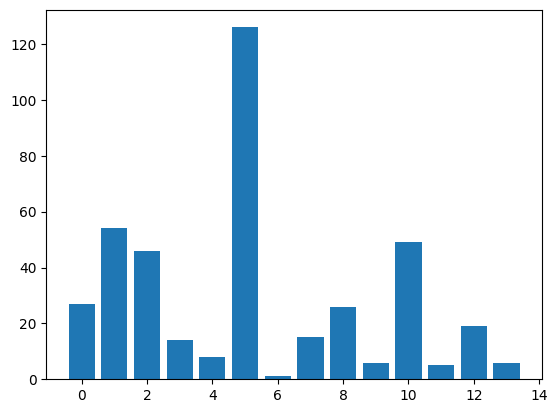

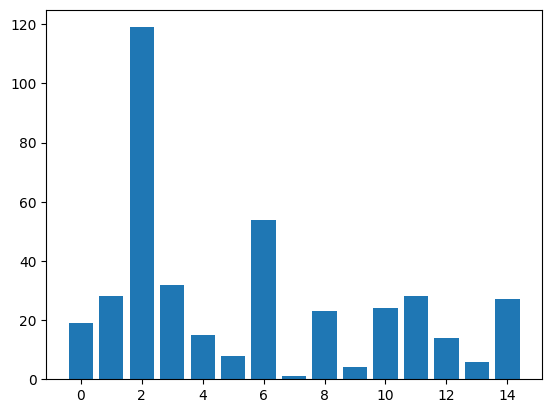

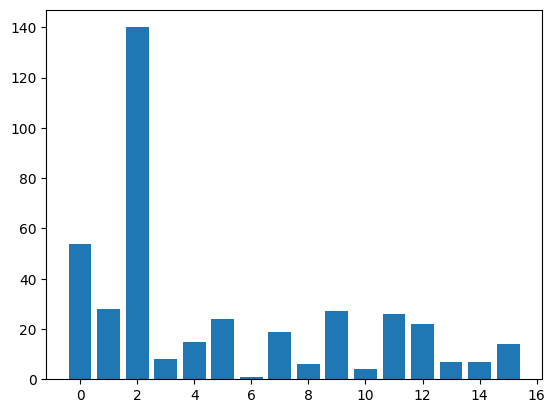

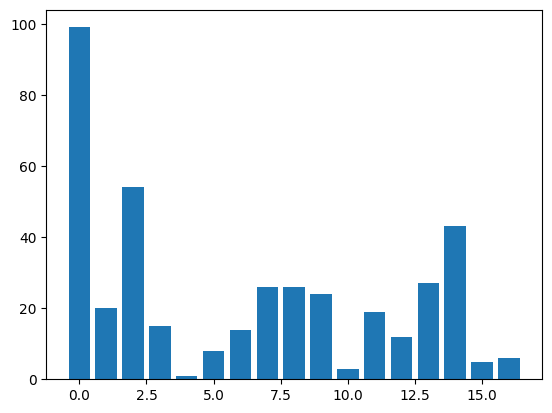

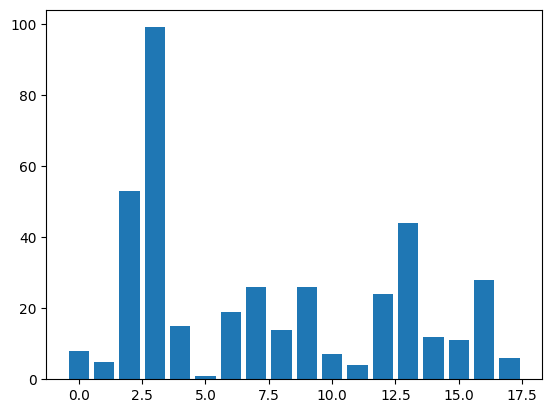

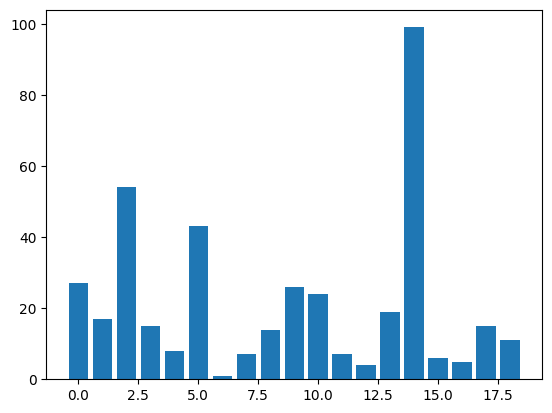

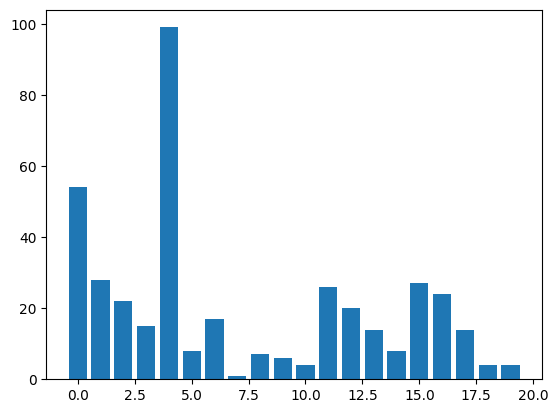

In [ ]:
def counts(result):
    bars = [0] * (max(result)+1)
    for value in result:
        bars[value] += 1
    return bars

for i in range(len(results)):
    result = results[i]
    plt.bar(range(0,max(result)+1), counts(result))
    plt.show()


In [18]:
instance_data[0].keys()

dict_keys(['name', 'n_jobs', 'n_machines', 'n_operations', 'durations', 'job_sequence', 'machines_for_all_operations', 'flexibility', 'duration_variety', 'average_operations', 'average_assignments', 'min_duration', 'max_duration', 'duration_span', 'duration_std'])

In [20]:
for instance in instance_data:
    print(f'{instance["name"]}: {instance["average_assignments"]}')

0_BehnkeGeiger_10_workers.fjs: 94.96
0_BehnkeGeiger_11_workers.fjs: 97.016
0_BehnkeGeiger_12_workers.fjs: 102.112
0_BehnkeGeiger_13_workers.fjs: 99.18
0_BehnkeGeiger_14_workers.fjs: 97.34
0_BehnkeGeiger_15_workers.fjs: 96.488
0_BehnkeGeiger_16_workers.fjs: 100.694
0_BehnkeGeiger_17_workers.fjs: 97.768
0_BehnkeGeiger_18_workers.fjs: 97.832
0_BehnkeGeiger_19_workers.fjs: 99.946
0_BehnkeGeiger_1_workers.fjs: 98.5
0_BehnkeGeiger_20_workers.fjs: 98.272
0_BehnkeGeiger_21_workers.fjs: 462.22
0_BehnkeGeiger_22_workers.fjs: 392.52
0_BehnkeGeiger_23_workers.fjs: 408.68
0_BehnkeGeiger_24_workers.fjs: 330.56
0_BehnkeGeiger_25_workers.fjs: 337.9
0_BehnkeGeiger_26_workers.fjs: 382.27
0_BehnkeGeiger_27_workers.fjs: 367.07
0_BehnkeGeiger_28_workers.fjs: 426.29
0_BehnkeGeiger_29_workers.fjs: 422.59
0_BehnkeGeiger_2_workers.fjs: 106.1
0_BehnkeGeiger_30_workers.fjs: 387.37
0_BehnkeGeiger_31_workers.fjs: 389.308
0_BehnkeGeiger_32_workers.fjs: 369.688
0_BehnkeGeiger_33_workers.fjs: 376.664
0_BehnkeGeiger_3

In [23]:
grouped_by_source = dict()
for instance in instance_data:
    prefix = instance['name'].split('_')[0]
    if prefix not in grouped_by_source:
        grouped_by_source[prefix] = []
    grouped_by_source[prefix].append(instance)

In [31]:
for group in grouped_by_source:
    data = grouped_by_source[group]
    assignments = [instance['n_assignments'] for instance in data]
    operations = [instance['n_operations'] for instance in data]
    flexibility = [instance['flexibility'] for instance in data]
    dv = [instance['duration_variety'] for instance in data]
    avg_assignments = statistics.mean(assignments)
    avg_operations = statistics.mean(operations)
    avg_flexibility = statistics.mean(flexibility)
    avg_duration_variety = statistics.mean(dv)
    print(f'{group} = n-{len(data)} | O-{avg_operations} | A-{avg_assignments} | F-{avg_flexibility} |  DV-{avg_duration_variety}')

0 = n-60 | O-225 | A-443.15936666666664 | F-0.31559 |  DV-0.009000000000000001
1 = n-15 | O-171.86666666666667 | A-17.87042994059558 | F-0.3103298455580747 |  DV-0.0076205040466922
2a = n-66 | O-133.37878787878788 | A-7.0258320308239135 | F-0.1309944684944685 |  DV-0.010307466553408112
2b = n-66 | O-133.37878787878788 | A-8.022289288092859 | F-0.1511374852523633 |  DV-0.010307466553408112
2c = n-66 | O-133.37878787878788 | A-13.841547251900336 | F-0.25788897314428616 |  DV-0.010307466553408112
2d = n-66 | O-133.37878787878788 | A-32.250309095365914 | F-0.4761788518638105 |  DV-0.010307466553408112
3 = n-18 | O-292 | A-16.20760009797736 | F-0.3301358696418395 |  DV-0.0036996631425894517
4 = n-21 | O-158.33333333333334 | A-12.56962962962963 | F-0.08888888888888889 |  DV-0.007037037037037037
5 = n-4 | O-31.75 | A-55.27687807881773 | F-1.0 |  DV-0.04225164203612479
6 = n-20 | O-17.4 | A-9.531221590909091 | F-0.5173262600494744 |  DV-0.09780799062049061
